# Анализ запуска тестов

В анализе тестов нас интересует как часто приближённый алгоритм даёт точный ответ и от чего может зависеть эта точность.

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="Set2")

Для сборка статистики в `json` формате необходимо запустить тесты следующим образом: 
```bash
$ STATISTICS=1 ./test --gtest_output=json
```

In [113]:
file = open("test_detail.json")
tests_suites = json.load(file)["testsuites"]
[ts["name"] for ts in tests_suites]

['ConstantProbability/RandomGraph',
 'LinearProbability/RandomGraph',
 'ReaderTests/AllSize6',
 'ReaderTests/AllSize7',
 'ReaderTests/AllSize8',
 'ReaderTests/AllSize9',
 'ReaderTests/AllEdges8',
 'ReaderTests/AllEdges9',
 'ReaderTests/AllEdges10',
 'ReaderTests/AllEdges11',
 'ReaderTests/AllEdges12',
 'ReaderTests/AllEdges13',
 'ReaderTests/AllEdges14',
 'ReaderTests/AllEdges15',
 'SimpleTests/CompleteGraph']

In [141]:
constant_tests = tests_suites[0]
linear_tests = tests_suites[1]
all_size_tests = tests_suites[2:6]
all_edges_tests = tests_suites[6:14]
complete_tests = tests_suites[14]

## Полные графы

In [4]:
def prepare_df(tests):
    df = pd.DataFrame(tests)
    res = pd.DataFrame()
    for col in ["size", "edges", "aproximated_minimum_degree"]:
        res[col] = df[col].apply(eval)
    res["optimal"] = df["is_optimal"].apply(lambda x: int(x == "true"))
    return res


df = prepare_df(complete_tests["testsuite"])
df.describe()

,size,edges,aproximated_minimum_degree,optimal
count,98.000000,98.000000,98.000000,98.0
mean,50.500000,1650.000000,1.989796,1.0
std,28.434134,1466.495823,0.101015,0.0
min,2.000000,1.000000,1.000000,1.0
25%,26.250000,331.500000,2.000000,1.0
50%,50.500000,1250.000000,2.000000,1.0
75%,74.750000,2756.500000,2.000000,1.0
max,99.000000,4851.000000,2.000000,1.0


То есть, алгоритм на полных графах всегда находил оптимальные значения.

## Наборы связных графов

In [144]:
size_df = pd.DataFrame()
for ts in all_size_tests:
    size_df = pd.concat([size_df, prepare_df(ts["testsuite"])])

edges_df = pd.DataFrame()
for ts in all_edges_tests:
    edges_df =pd.concat([edges_df, prepare_df(ts["testsuite"])])

In [22]:
pd.pivot_table(size_df, "size", "aproximated_minimum_degree", "optimal", "count")

optimal,0,1
aproximated_minimum_degree,,
2,NaN,222508.0
3,36774.0,13120.0
4,1.0,663.0
5,NaN,78.0
6,NaN,14.0
7,NaN,3.0
8,NaN,1.0


In [21]:
pd.pivot_table(edges_df, "edges", "aproximated_minimum_degree", "optimal", "count")

optimal,0,1
aproximated_minimum_degree,,
2,NaN,152483.0
3,244717.0,1464123.0
4,18169.0,440355.0
5,61.0,111936.0
6,NaN,29062.0
7,NaN,7765.0
8,NaN,2130.0
9,NaN,608.0
10,NaN,177.0


Таким образом, на использованных наборах графов, алгоритм чаще всего ошибается, когда находит остовное дерево степени 3.

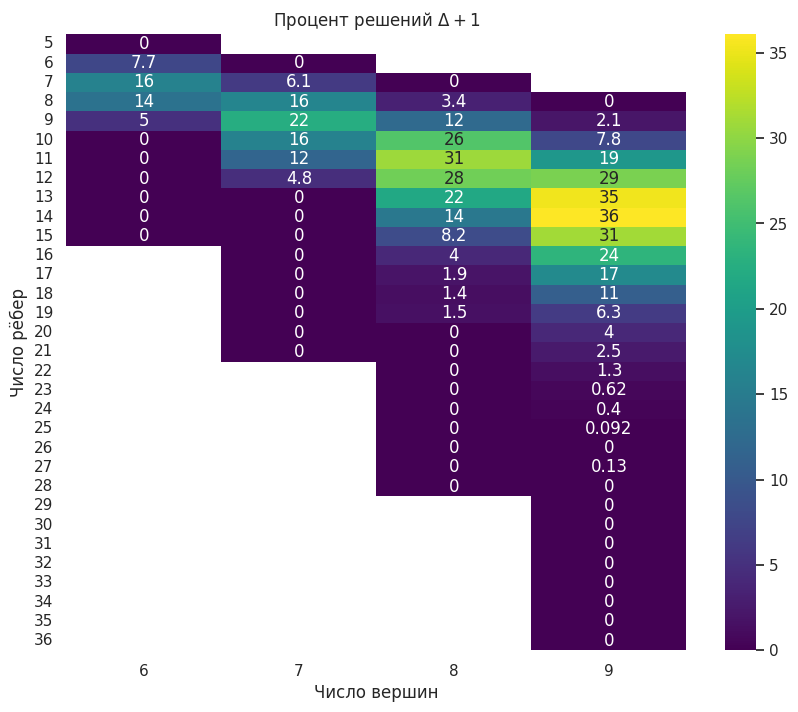

In [148]:
plt.figure(figsize=(10,8))
ax = sns.heatmap((1-pd.pivot_table(size_df, "optimal", "edges", "size", "mean"))*100, annot=True, cmap='viridis')
ax.set_xlabel('Число вершин')
ax.set_ylabel('Число рёбер')
ax.set_title('Процент решений $\Delta + 1$');

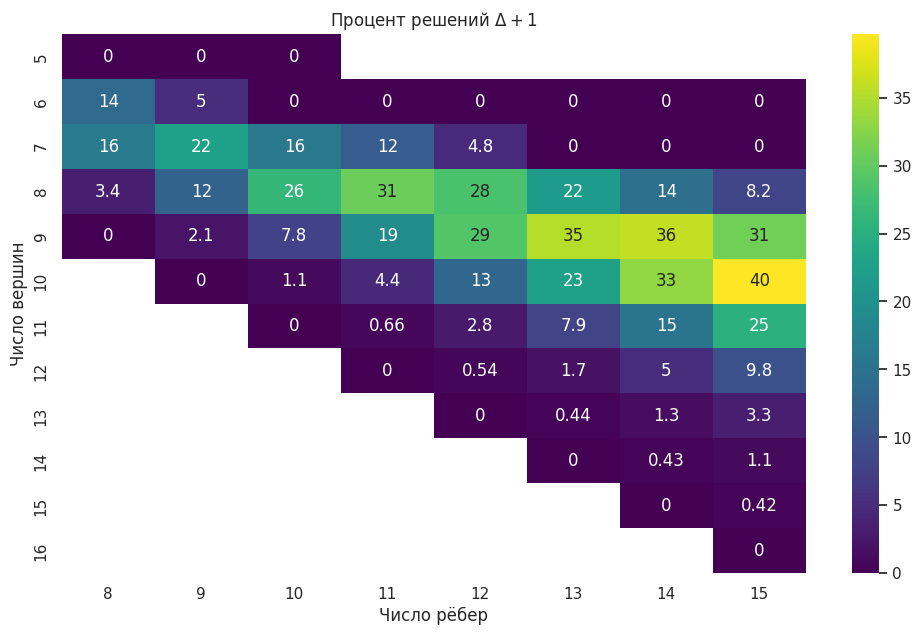

In [145]:
plt.figure(figsize=(12,7))
ax = sns.heatmap((1-pd.pivot_table(edges_df, "optimal", "size", "edges", "mean"))*100, annot=True, cmap='viridis')
ax.set_xlabel('Число рёбер')
ax.set_ylabel('Число вершин')
ax.set_title('Процент решений $\Delta + 1$');

Из данных тепловых карт, можно сделать вывод, что на граничных случаях (дерево и полный граф), алгоритм всегда даёт точный ответ, а при средней плотности графа алгоритм иногда ошибается.

## Случайные графы

Каждый случайный тест запускался по 100 раз для достижения статистической устойчивости. Тестировались случайные графы $G(n,c)$ и $G(n, \frac{c}{n})$

In [96]:
def prepare_df(tests):
    df = pd.DataFrame(tests)
    res = pd.DataFrame()
    for col in ["size", "edges", "aproximated_minimum_degree"]:
        res[col] = df[col].apply(eval)
    res["optimal"] = df["is_optimal"].apply(lambda x: int(x == "true"))
    res["coefficient"] = df["value_param"].apply(
        lambda x: eval(x.split(",")[2])
    )
    return res


constant_df = prepare_df(constant_tests["testsuite"])
linear_df = prepare_df(linear_tests["testsuite"])

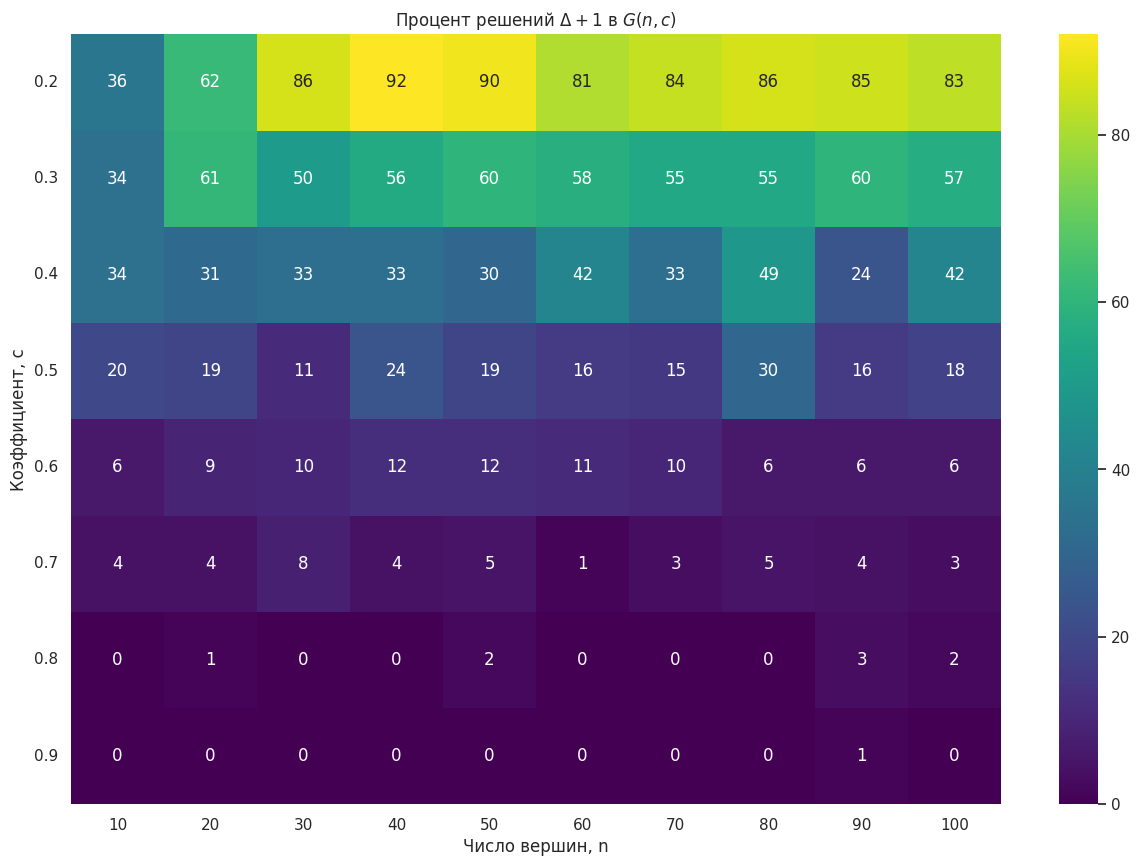

In [137]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    (1 - pd.pivot_table(constant_df, "optimal", "coefficient", "size", "mean")) * 100,
    annot=True,
    cmap="viridis",
)
ax.set_yticklabels([f"{t/10:.1f}" for t in range(2, 10)])
ax.set_xlabel("Число вершин, n")
ax.set_ylabel("Коэффициент, c")
ax.set_title("Процент решений $\Delta + 1$ в $G(n,c)$")

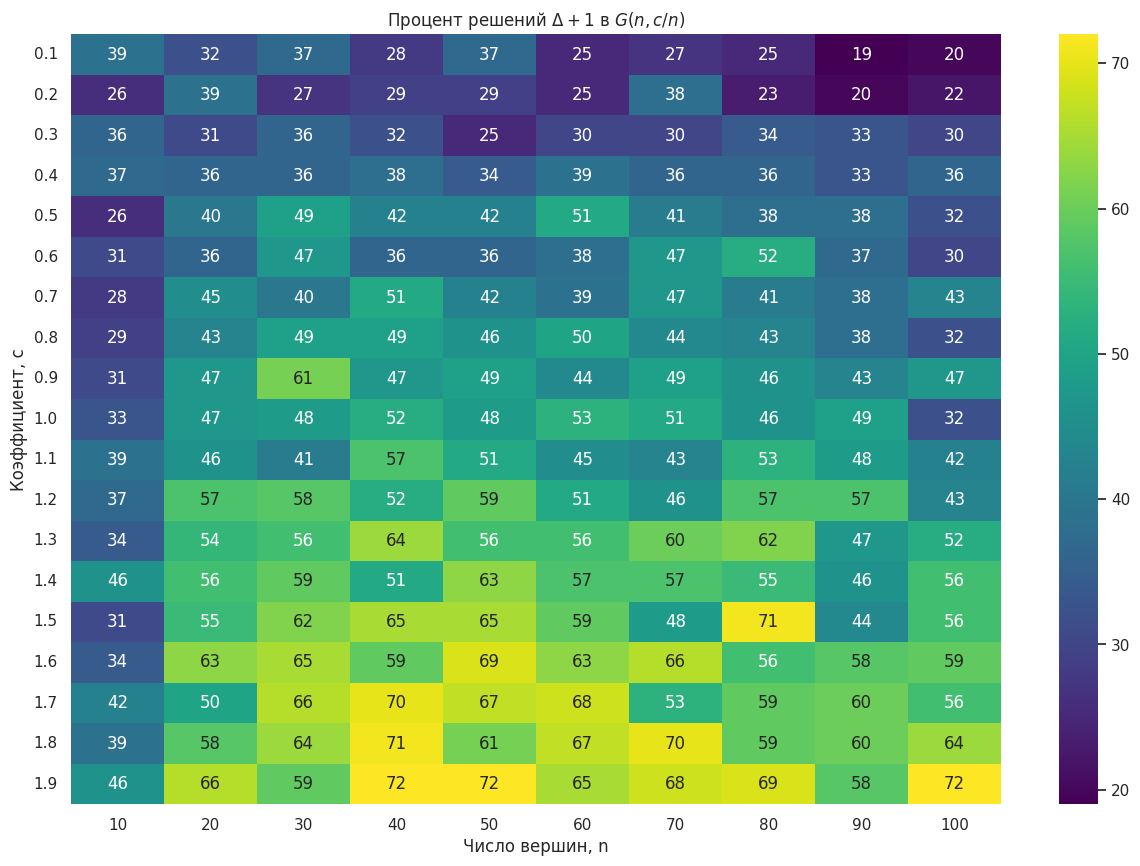

In [138]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    (1 - pd.pivot_table(linear_df, "optimal", "coefficient", "size", "mean")) * 100,
    annot=True,
    cmap="viridis",
)
ax.set_yticklabels([f"{t/10:.1f}" for t in range(1, 20)])
ax.set_xlabel("Число вершин, n")
ax.set_ylabel("Коэффициент, c")
ax.set_title("Процент решений $\Delta + 1$ в $G(n,c/n)$")

Из построенных тепловых карт можно заметить, что точность алгоритма меняется в обоих случиях вдоль столбцов и остаётся примерно равной вдоль строчек, что говорит о том, что точность слабо зависит от размера графа. Гораздо заметнее точность зависит от вероятности ребра в случайном графе, которая напрямую влияет на плотность графа. 
* В случае графа $G(n, c)$ при $c \ge 0.5$ граф становится достаточно плотным и поэтому приближённый алгоритм чаще находит точный ответ. 
* В случае графа $G(n, \frac{c}{n})$ при меньших значениях параметра $c$ граф является наиболее разряжённым и поэтому алгоритм реже находит неточный ответ. 

# Анализ производительности

В анализе производительности нас интересует насколько теоритическая оценка времени работы алгоритма сопоставляется с реальным временем работы.

In [9]:
file = open('linear.json')
benchmarks_df = pd.DataFrame(json.load(file)["benchmarks"])
benchmarks_df = benchmarks_df[benchmarks_df['run_type']=='iteration']
complete_df = benchmarks_df[benchmarks_df['family_index'] == 0]
constant_df = benchmarks_df[benchmarks_df['family_index'] == 1]
linear_df = benchmarks_df[benchmarks_df['family_index'] == 2]

In [ ]:
complete_df["size"] = complete_df["run_name"].str.split("/").str[1].astype(int)
complete_df = complete_df[["size", "cpu_time"]]

def prepare(df):
    splitted = df["run_name"].str.split("/")
    df["size"] = splitted.str[1].astype(int)
    df["coefficient"] = splitted.str[2].astype(int)
    return df[["size", "coefficient", "cpu_time"]]

constant_df = prepare(constant_df)
linear_df = prepare(linear_df)

complete_df["coefficient"] = 100
df = pd.concat([constant_df, complete_df])

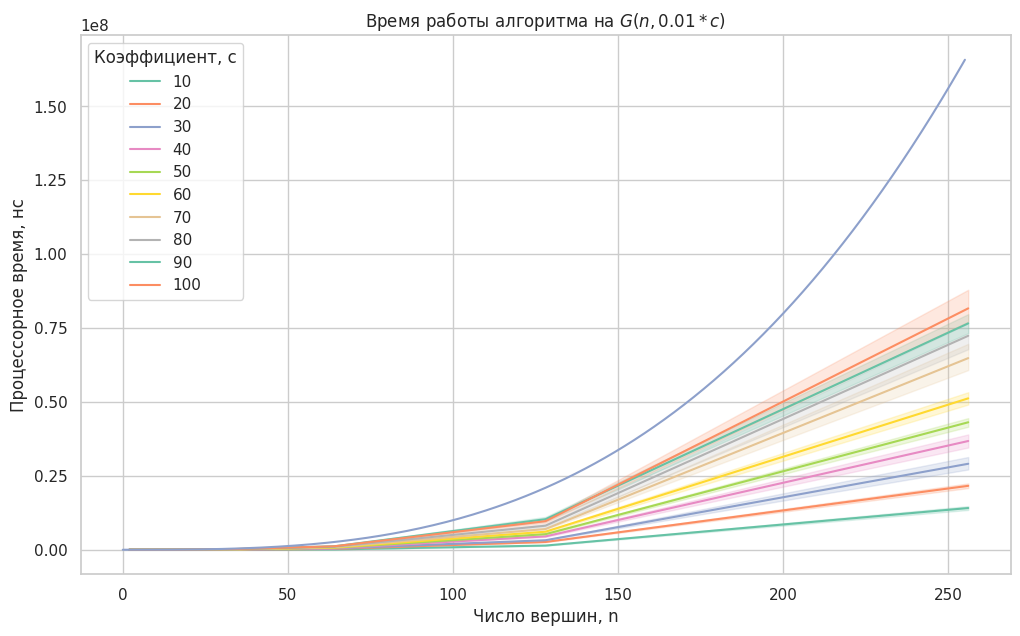

In [90]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(df, x="size", y="cpu_time", hue="coefficient", palette="Set2")
ax.set_xlabel("Число вершин, n")
ax.set_ylabel("Процессорное время, нс")
ax.set_title("Время работы алгоритма на $G(n, 0.01 * c)$")
ax.legend_.set_title("Коэффициент, c");
ax.plot(np.arange(256), 10 * np.power(np.arange(256), 3));

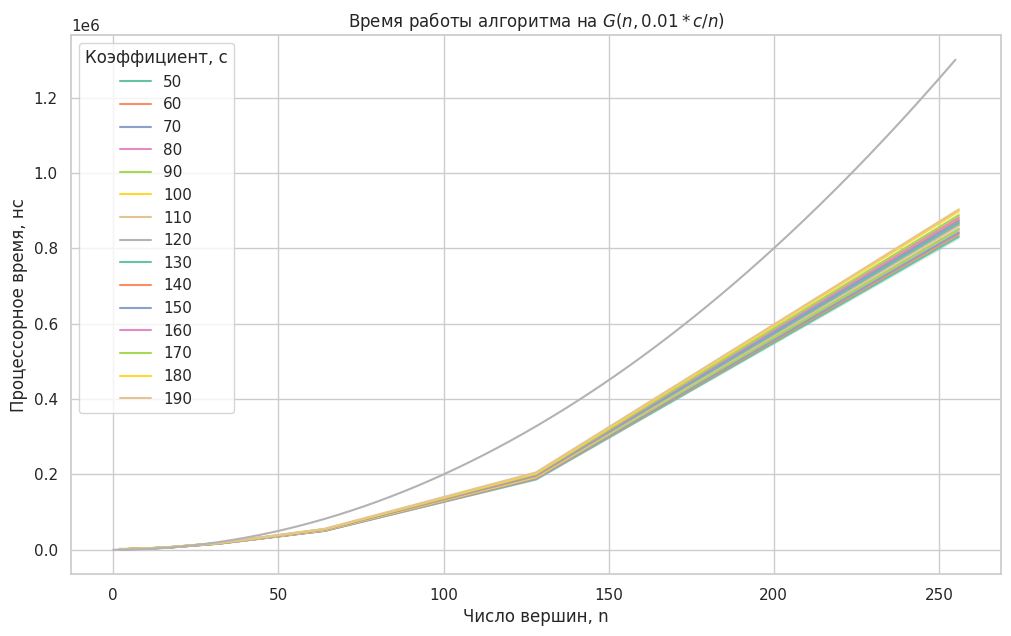

In [89]:
plt.figure(figsize=(12,7))
ax = sns.lineplot(linear_df, x="size", y="cpu_time", hue="coefficient", palette="Set2")
ax.set_xlabel("Число вершин, n")
ax.set_ylabel("Процессорное время, нс")
ax.set_title("Время работы алгоритма на $G(n, 0.01 * c / n)$")
ax.legend_.set_title("Коэффициент, c");
ax.plot(np.arange(256), 20 * np.power(np.arange(256), 2));

Таким образом из визуального сравнения можно предположить, что
* $T(G(n, c)) = O(n^3)$
* $T(G(n, \frac{c}{n}) = O(n^2)$

Из анализа асимптотики алгоритма, мы получили оценку $O(n^2m\log n \cdot \alpha(m,n))$. Для графов $G(n, c)$ и $G(n, c/n)$ матожидание числа рёбер $Em = O(cn^2)$ и $Em = O(cn)$ соответственно, поэтому ожидаемые асимптотики были $O(n^4 \log n)$ и $O(n^3 \log n)$, считая $\alpha(m,n)$ ограниченной константой при рассматриваемых значениях $n$.

Таким образом, на практике время работы алгоритма на порядок меньше теоретической оценки.  

# Анализ профилирования

При профилировании нас интересуют узкие места алгоритма. 

![flamegraph](profile.svg)

По результатам профилирования алгоритма на полном графе с 100 вершинами был построен [flamegraph](https://www.brendangregg.com/FlameGraphs/cpuflamegraphs.html).

Как видно из этого графа, большую часть времени алгоритм ищет путь между двумя вершинами в методе `FindCycle` с помощью `DFS` и много раз ищет ребро для улучшения остовного дерева. Так что при дальнейших оптимизациях алгоритма, стоит обратить на это внимание.